## Installing

In [1]:
!pip3 install regex pandas numpy scikit-learn wordcloud matplotlib '''gensim''' transformers nltk yellowbrick seaborn --upgrade sentence-transformers "tensorflow>=1.7.0" tensorflow-hub umap-learn

  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 11.3 MB/s eta 0:00:00m eta 0:00:010:01:01
Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 11.3 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 10.8 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 5.0 MB/s eta 0:00:00m eta 0:00:01m0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:000m eta 0:00:01:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 9.4 MB/s eta 0:00:00m eta 0:00:010:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 7.7 MB/s eta 0:00:007.7 MB/s e

In [2]:
import re
import math
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator


## Loading the data

In [3]:
#### wordcloud
MAX_WORDS = 20
COLLOCATION = 1 #5
COLLOCATIONS = False

In [4]:
DATA = "../Errors_data.csv"

df = pd.read_csv(DATA,header=None, names=['Error', 'Category','x','y'])
df = df.drop(['x','y'], axis=1)
df.head(10)


,Error,Category
0,Missing package-info java file,JavadocPackage
1,Utility classes should not have a public or de...,HideUtilityClassConstructor
2,Missing a Javadoc comment,MissingJavadocMethod
3,Parameter args should be final,FinalParameters
4,File contains tab characters (this is the firs...,FileTabCharacter
5,Line has trailing spaces,RegexpSingleline
6,Line has trailing spaces,RegexpSingleline
7,Line is longer than characters (found ),LineLength
8,Line has trailing spaces,RegexpSingleline
9,Line is longer than characters (found ),LineLength


In [5]:
df.shape

(13993, 2)

In [6]:
print("Total unique categories:", df['Category'].nunique())

Total unique categories: 65


In [7]:
math.sqrt(df['Category'].nunique())

8.06225774829855

In [8]:
df.iloc[182]['Error']

"'||' is not preceded with whitespace"

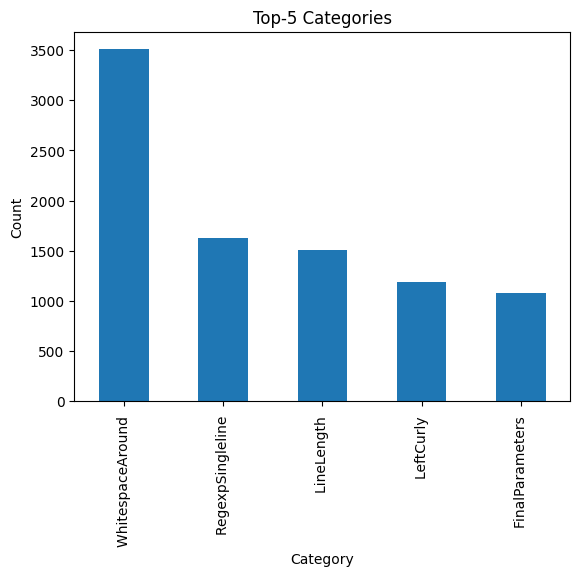

In [9]:
# df['Ctegory'].value_counts().plot.bar()

ax = df['Category'].value_counts().head(5).plot.bar()

ax.set_title('Top-5 Categories')
ax.set_xlabel('Category')
ax.set_ylabel('Count')

plt.show()

In [10]:
# Remove whitespace around plot
fig = ax.get_figure()
fig.tight_layout()

# Save just the plot area to PDF
fig.savefig('./top5_category.pdf', bbox_inches='tight')

<Axes: xlabel='Category'>

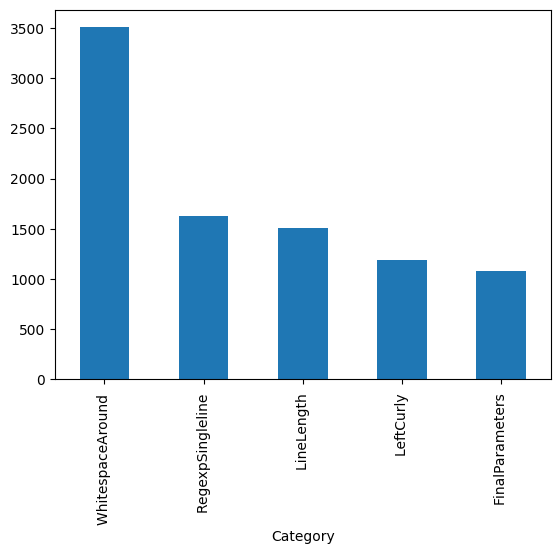

In [11]:
df['Category'].value_counts().head(5).plot.bar()

<Axes: xlabel='Category'>

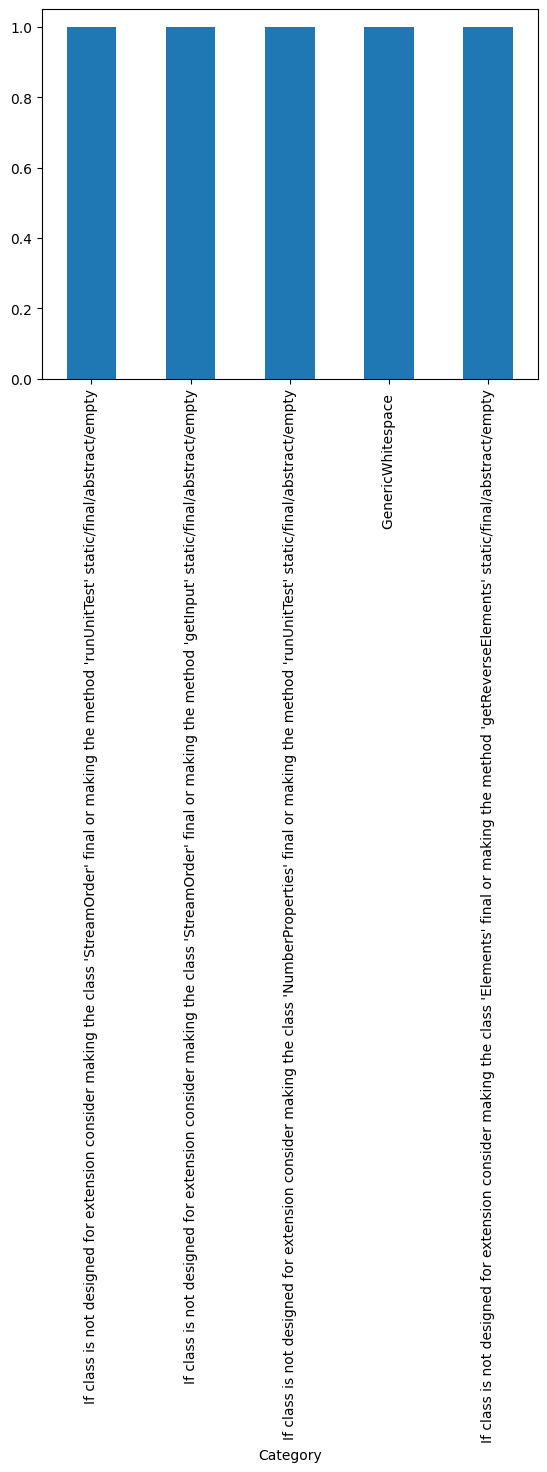

In [12]:
df['Category'].value_counts().tail(5).plot.bar()

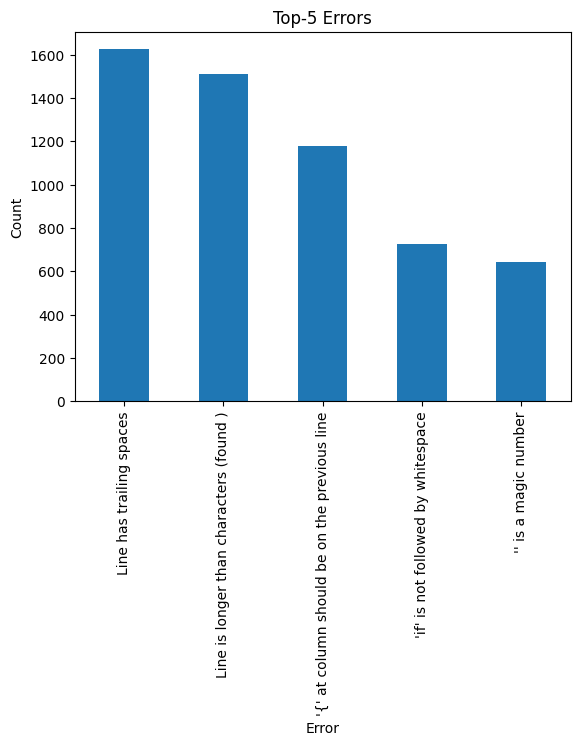

In [13]:
# df['Ctegory'].value_counts().plot.bar()

ax = df['Error'].value_counts().head(5).plot.bar()

ax.set_title('Top-5 Errors')
ax.set_xlabel('Error')
ax.set_ylabel('Count')

plt.show()

In [14]:
# Remove whitespace around plot
fig = ax.get_figure()
# fig.tight_layout()

# Save just the plot area to PDF
fig.savefig('./top5_error.pdf', bbox_inches='tight')

## Preprocessing the data

In [15]:
def preprocessing(text):

    # text = text.replace("/home/imhmede/workspace/hello.java:", "")
    # text = text.split()
    # text = [txt for i, txt in enumerate(text) if i!= 1]
    # print(text)
    # text = " ".join(text)
    # text = change_construct(text)
    # text = re.sub(r'[^\w\s\<\>]', '', text)
    # text = [txt.strip() for txt in text.split() if not txt.isdigit()]
    # text = " ".join(text)
    # text = text.replace('_', '')
    # text = text.lower()
    # text = text.replace("error", "<ERROR>")
    # text = text.replace("warn", "<WARN>")
    # # txt = re.sub(' +', ' ', text)
    # text = text.split()
    # text = " ".join(text)
    text = change_name_next(text)
    # text = change_def_next(text)
    text = change_class_next(text)
    text = change_method_next(text)
    text = change_brackets(text)
    text = change_isnot(text)
    text = change_construct(text)
    text = change_use_brackets(text)
    text = change_shouldbe(text)
    text = change_parameter_next(text)

    text = text.lower()
    return text


In [16]:
def change_name_next(text):
    l = text.split()
    j = ['<A_NAME>' if i>0 and l[i-1] in ["Name"] else l[i] for i in range(len(l))]
    return ' '.join(j)


In [17]:
def change_def_next(text):
    l = text.split()
    j = ['<A_FUNC_NAME>' if i>0 and l[i-1] in ["def"] else l[i] for i in range(len(l))]
    return ' '.join(j)


In [18]:
def change_class_next(text):
    l = text.split()
    j = ['<A_CLASS_NAME>' if i>0 and l[i-1] in ["Class"] else l[i] for i in range(len(l))]
    return ' '.join(j)


In [19]:
def change_parameter_next(text):
    l = text.split()
    j = ['<A_PARAMETER_NAME>' if i>0 and l[i-1] in ["Parameter"] else l[i] for i in range(len(l))]
    return ' '.join(j)


In [20]:
def change_method_next(text):
    l = text.split()
    j = ['<A_METHOD_NAME>' if i>0 and l[i-1] in ["method"] else l[i] for i in range(len(l))]
    return ' '.join(j)


In [21]:
def change_brackets(text):
    return re.sub(r"'[{()}]'", "<BRAKET>", text)

In [22]:
def change_construct(text):
    return re.sub(r"'[a-zA-Z]+'", "<CONSTRUCT>", text)

In [23]:
def change_isnot(text):
  if " is not" in text:
    new_text = re.sub(r'(^.*) is not', r'<OPERATOR> is not', text)
  else:
    new_text = text

  return new_text

In [24]:
def change_shouldbe(text):
  if " should be on" in text:
    new_text = re.sub(r'(^.*) should be on', r'<OPERATOR> should be on', text)
  else:
    new_text = text

  return new_text

In [25]:
def change_construct(text):
  if " construct must use" in text:
    new_text = re.sub(r'(^.*) construct must use', r'<OPERATOR> construct must use', text)
  else:
    new_text = text

  return new_text

In [26]:
def change_use_brackets(text):
  if "'{}'s" in text:
    new_text = re.sub(r"'{}'s", r"<BRACKET>", text)
  else:
    new_text = text

  return new_text

In [27]:
# n_text = preprocessing(content_list[160])
# print(n_text)


In [28]:
# id_ = 1002
id_ = 103
print(df.iloc[id_]['Error'])

n_text = preprocessing(df.iloc[id_]['Error'])
print(n_text)

'*' is not followed by whitespace
<operator> is not followed by whitespace


## Create a dataframe

In [29]:
df['clean'] = df['Error'].apply(preprocessing)

In [30]:
df.head()

,Error,Category,clean
0,Missing package-info java file,JavadocPackage,missing package-info java file
1,Utility classes should not have a public or de...,HideUtilityClassConstructor,utility classes should not have a public or de...
2,Missing a Javadoc comment,MissingJavadocMethod,missing a javadoc comment
3,Parameter args should be final,FinalParameters,parameter <a_parameter_name> should be final
4,File contains tab characters (this is the firs...,FileTabCharacter,file contains tab characters (this is the firs...


In [31]:
df.iloc[1]["clean"]

'utility classes should not have a public or default constructor'

In [32]:
df.iloc[114]["clean"]

'<operator> is not preceded with whitespace'

In [33]:
df.iloc[114]["clean"]

'<operator> is not preceded with whitespace'

## Create a Word Cloud

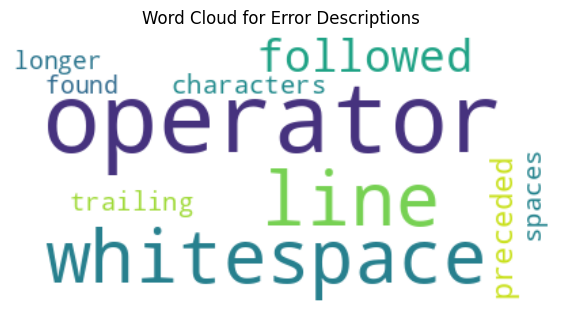

In [34]:
all_text = []
def get_all_text(text):
    all_text.append(text)

df["clean"].apply(get_all_text)
text = "\n".join(all_text)
# print(text)

# wordcloud = WordCloud(background_color="white").generate(text)

#Create the wordcloud object
wordcloud = WordCloud(collocations= False,
                        background_color="white",
                        collocation_threshold = 100,
                        max_words = 10,
                        relative_scaling = 1).generate(text)
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.title("Word Cloud for Error Descriptions")
plt.savefig("./wordcloud.pdf", bbox_inches='tight')
plt.show()

In [35]:
# Process text
frequencies = wordcloud.process_text(text)

print(frequencies)

{'missing': 890, 'package': 395, 'info': 390, 'java': 453, 'file': 650, 'utility': 378, 'classes': 378, 'public': 378, 'default': 380, 'constructor': 378, 'javadoc': 713, 'comment': 691, 'parameter': 1080, 'a_parameter_name': 1080, 'final': 1080, 'contains': 370, 'tab': 72, 'characters': 1582, 'first': 279, 'instance': 72, 'line': 4668, 'trailing': 1624, 'spaces': 1624, 'longer': 1510, 'found': 1510, 'magic': 711, 'number': 711, 'operator': 6039, 'preceded': 1853, 'whitespace': 4656, 'previous': 1193, 'followed': 2803, 'end': 394, 'newline': 187, 'array': 49, 'illegal': 47, 'position': 47, 'construct': 131, 'must': 508, 'use': 131, 'bracket': 178, 'placed': 191, 'wrong': 191, 'location': 191, 'next': 298, 'part': 298, 'multi': 298, 'block': 600, 'statement': 341, 'one': 300, 'directly': 298, 'multiple': 298, 'try': 298, 'catch': 298, 'finally': 298, 'unused': 92, 'import': 65, 'io': 12, 'name': 317, 'a_name': 316, 'match': 315, 'pattern': 315, 'za': 627, 'z': 315, "int'": 26, 'sentence

## Using Bert

In [36]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [37]:
DIMENSIONS = 64
WINDOW = 5

In [38]:
all_texts = df['clean'].tolist()
all_texts = [text.split() for text in all_texts]
print(len(all_texts))

13993


In [39]:
print(all_texts[:2])
print(all_texts[-2:])

[['missing', 'package-info', 'java', 'file'], ['utility', 'classes', 'should', 'not', 'have', 'a', 'public', 'or', 'default', 'constructor']]
[['line', 'has', 'trailing', 'spaces'], ['line', 'has', 'trailing', 'spaces']]


In [40]:
df["textList"] = all_texts

In [41]:
df

,Error,Category,clean,textList
0,Missing package-info java file,JavadocPackage,missing package-info java file,"[missing, package-info, java, file]"
1,Utility classes should not have a public or de...,HideUtilityClassConstructor,utility classes should not have a public or de...,"[utility, classes, should, not, have, a, publi..."
2,Missing a Javadoc comment,MissingJavadocMethod,missing a javadoc comment,"[missing, a, javadoc, comment]"
3,Parameter args should be final,FinalParameters,parameter <a_parameter_name> should be final,"[parameter, <a_parameter_name>, should, be, fi..."
4,File contains tab characters (this is the firs...,FileTabCharacter,file contains tab characters (this is the firs...,"[file, contains, tab, characters, (this, is, t..."
...,...,...,...,...
13988,Parameter args should be final,FinalParameters,parameter <a_parameter_name> should be final,"[parameter, <a_parameter_name>, should, be, fi..."
13989,Line has trailing spaces,RegexpSingleline,line has trailing spaces,"[line, has, trailing, spaces]"
13990,Line has trailing spaces,RegexpSingleline,line has trailing spaces,"[line, has, trailing, spaces]"
13991,Line has trailing spaces,RegexpSingleline,line has trailing spaces,"[line, has, trailing, spaces]"


In [42]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(all_texts)]

### Get embeddings for multiple dimensions

In [43]:
import tensorflow_hub as hub
import tensorflow as tf
# elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True) ### Doesn't work on colab

elmo = hub.load("https://tfhub.dev/google/elmo/2")

from tqdm import tqdm
tqdm.pandas()

if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("No GPU found")

2023-12-04 23:25:18.606803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-04 23:25:18.606829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-04 23:25:18.607888: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-04 23:25:18.613155: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 23:25:19.214963: W tensorflow/compiler/tf2

No GPU found


In [44]:
# def elmo_vectors(x):
#   embeddings = elmo(x.tolist(), signature="default", as_dict=True)["elmo"]

#   with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(tf.tables_initializer())
#     # return average of ELMo features
#     return sess.run(tf.reduce_mean(embeddings,1))


def elmo_vectors(x):
    embeddings = elmo.signatures["default"](tf.constant(x))["elmo"]
    return embeddings.numpy()

In [45]:
def preprocess_text(x):
        return x.split(' ')

In [46]:
df['cleanV2'] = df['clean'].progress_apply(preprocess_text)
df['embedding_bert'] = df['cleanV2'].progress_apply(elmo_vectors)

df.to_pickle("Pickled")

 64%|████████████████████████▎             | 8951/13993 [04:49<02:43, 30.91it/s]


KeyboardInterrupt: 

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_pickle("Pickled")

In [ ]:
print(df.head())

In [ ]:
def extract_value(embedding_list):
    return embedding_list[0][0]

print(df['embedding_bert'].shape)
print(df['embedding_bert'][0].shape)
print(df['embedding_bert'][0][0].shape)
print(df['embedding_bert'][0][0][0].shape)

df['embedding']=df['embedding_bert'].apply(extract_value)

print("\nAfter")
print(df['embedding'].shape)
print(df['embedding'][0].shape)

### Get the explained variance

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# PCA analysis
variance_explained = []
col = 'embedding'
print(col)
embeddings=df[col].tolist()
pca = PCA(n_components=2)
pca.fit(embeddings)
variance_explained.append(pca.explained_variance_ratio_.sum().round(2))

In [ ]:
print(variance_explained)

In [ ]:
# # Plot variance explained
# import matplotlib.pyplot as plt
# plt.plot(dims, variance_explained)
# # Set x ticks
# plt.xticks(dims,rotation=90)

# plt.title('Variance Explained vs Dimensionality')
# plt.xlabel('Dimensions')
# plt.ylabel('Variance Explained')
# plt.savefig("./embeddings_variance.pdf", bbox_inches='tight')
# plt.show()

## Let's find the best k for clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score


In [ ]:
# Range of k to check
k_range = range(2, 20)

sil_scores = []
cal_scores = []

for k in k_range:
  # Cluster data into k clusters
  kmeans = KMeans(n_clusters=k)
  clusters = kmeans.fit_predict(df['embedding'][0].reshape(-1, 1).tolist())

  # Score with metrics
  sil_score = silhouette_score(df['embedding'][0].reshape(-1, 1).tolist(), clusters)
  sil_scores.append(sil_score)

  cal_score = calinski_harabasz_score(df['embedding'][0].reshape(-1, 1).tolist(), clusters)
  cal_scores.append(cal_score)


In [ ]:
# Plot scores
plt.plot(k_range, sil_scores, label='Silhouette')
new_list = range(math.floor(min(k_range)), math.ceil(max(k_range))+1)
plt.xticks(new_list)
plt.title('Silhouette Cluster Evaluation Scores')
plt.xlabel('Size of k')
plt.ylabel('Score')
#plt.legend()
plt.savefig("./shilouette_k.pdf", bbox_inches='tight')
plt.show()

In [ ]:
print(sil_scores)

In [ ]:
# Plot scores
plt.plot(k_range, cal_scores, label='Calinski-Harabasz')
new_list = range(math.floor(min(k_range)), math.ceil(max(k_range))+1)
plt.xticks(new_list)
plt.title('Cluster Evaluation Scores')
plt.xlabel('k')
plt.legend()
plt.show()

It looks that k=7 is fine

### Lets use the 128 dimensions and 7 clusters

In [ ]:
all_d2v_vecs = df['embedding'].tolist()

In [ ]:
np.shape(all_d2v_vecs)

In [ ]:
all_d2v_vecs[0]

In [ ]:
CLUSTER_COUNT=13

In [ ]:
kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=0).fit(all_d2v_vecs)

In [ ]:
kmeans.labels_

In [ ]:
df["d2v_clusters"] = kmeans.labels_
df

In [ ]:
ax = df['d2v_clusters'].value_counts().plot.bar()

ax.set_title('Distribution of Clusters')
ax.set_xlabel('Clusters')
ax.set_ylabel('Number of Errors')

plt.show()

In [ ]:
# Remove whitespace around plot
fig = ax.get_figure()
# fig.tight_layout()

# Save just the plot area to PDF
fig.savefig('./hist_clusters.pdf', bbox_inches='tight')

In [ ]:
clust_number = 2
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 0
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 5
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 1
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 6
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 3
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

In [ ]:
clust_number = 4
print(df[df['d2v_clusters'] == clust_number]['clean'])
print(df[df['d2v_clusters'] == clust_number]['clean'].count())

### Silhouette Score

In [ ]:

from yellowbrick.cluster import SilhouetteVisualizer


# Assuming 'embedding128' is your pandas Series containing embeddings
# Convert the Series to a list of lists
embedding_list = df['embedding'].tolist()
embedding_list_of_lists = np.array([embedding.tolist() for embedding in embedding_list])

# Create a SilhouetteVisualizer instance
title = "Silhouette Plot of k-means Clustering"
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', title=title)


# Fit the visualizer with the standardized embedding data
visualizer.fit(embedding_list_of_lists)
# Export the plot to a PDF with a tight layout
visualizer.show(outpath="./silhouette_plot.pdf")

# Display the visualization
visualizer.poof()

### Let's use UMAP to plot the clusters


In [ ]:
data_embeds = pd.DataFrame()
data_embeds['embeds'] = df["embedding"]
print(data_embeds.head())
print(data_embeds.shape)


In [ ]:
!pip install umap-learn

In [ ]:
import umap.umap_ as umap # REDUCE DIMENSIONALITY
import seaborn as sns
sns.color_palette('colorblind')

In [ ]:
X_umap = umap.UMAP().fit_transform(data_embeds['embeds'].tolist())

In [ ]:
X_umap

In [ ]:
data_df = pd.DataFrame()
data_df['x'] = X_umap[:,0]
data_df['y'] = X_umap[:, 1]
data_df['cluster'] = df['d2v_clusters']

In [ ]:
data_df

In [ ]:
data_df['clus'] = data_df['cluster'].apply(lambda x: str(x))
data_df

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=data_df, x="x", y="y", hue='clus')
plt.savefig("./full_clusters.pdf", bbox_inches='tight')
plt.show()

What about PCA and Doc2Vec?

In [ ]:
#Getting unique labels
pca = PCA(2)
#Transform the data
X_pca = pca.fit_transform(data_embeds['embeds'].tolist())
X_pca

In [ ]:
data_df = pd.DataFrame()
data_df['x'] = X_pca[:,0]
data_df['y'] = X_pca[:, 1]
data_df['cluster'] = df['d2v_clusters']

In [ ]:
data_df

In [ ]:
data_df['clus'] = data_df['cluster'].apply(lambda x: str(x))
data_df

In [ ]:
plt.figure(figsize=(7,7))
sns.scatterplot(data=data_df, x="x", y="y", hue='clus')

plt.title("Clusters of errors")
plt.savefig("./cluster_errors.pdf", bbox_inches='tight')
plt.show()

### t-SNE

## Let's get error closest to the centroid in each cluster

In [ ]:
centroids = kmeans.cluster_centers_

In [ ]:
len(centroids)

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
# Find closest to each centroid
closest_docs = []
for c, centroid in enumerate(centroids):
    nbrs = NearestNeighbors(n_neighbors=1).fit(df[df['d2v_clusters']==c]['embedding'].tolist())
    distances, indices = nbrs.kneighbors(centroid.reshape(1,-1))
    closest_doc = df[df['d2v_clusters']==c]['clean'].iloc[indices[0,0]]
    closest_doc_cat = df[df['d2v_clusters']==c]['Category'].iloc[indices[0,0]]
    closest_docs.append({c:[closest_doc, closest_doc_cat]})

In [ ]:
closest_docs

### Checking the XML file

* {0: ['parameter <a_parameter_name> should be final', 'FinalParameters ']}, Miscellaneous other checks.
* {1: ['<operator> is not preceded with whitespace', 'WhitespaceAround ']}, Checks for whitespace.
* {2: ['line is longer than characters (found )', 'LineLength ']},Checks for Size Violations
* {3: ['<braket> is followed by whitespace', 'ParenPad ']},Checks for whitespace    
* {4: ['line has trailing spaces', 'RegexpSingleline ']},Miscellaneous other checks.
*  {5: ["name <a_name> must match pattern '^a-za-za-z-*$'", 'TypeName ']},Checks for Naming Conventions.
* {6: ['missing a javadoc comment', 'MissingJavadocMethod ']},Checks for Javadoc comments


## Let's try summarizing the whole cluster

In [ ]:
!pip3 install gensim==3.6.0 # summarization was deprecated from 4.0

In [ ]:
from gensim.summarization import summarize

In [ ]:
# Group docs by cluster
docs_by_cluster = df.groupby('d2v_clusters')['Error']

In [ ]:
texts = []
for d in docs_by_cluster:
    #print(d[1].values)
    text = ".".join(txt for txt in d[1].values)
    texts.append(text)

In [ ]:
len(texts)

In [ ]:
# Generate summary for each cluster (didn't work well)
#cluster_summaries = {}
#for cluster_id, cluster_docs in enumerate(texts):
#    #all_text = " ".join(cluster_docs.values)
#    #print(cluster_docs)
#    summary = summarize(cluster_docs, word_count=10)
#    cluster_summaries[cluster_id] = summary

In [ ]:
texts[0]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[0])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[0])

print(frequencies)

In [ ]:
texts[1]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[1])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[1])

print(frequencies)

In [ ]:
texts[2]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[2])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[2])

print(frequencies)

In [ ]:
texts[3]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[3])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[3])

print(frequencies)

In [ ]:
texts[4]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[4])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[4])

print(frequencies)

In [ ]:
texts[5]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[5])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
# Process text
frequencies = wordcloud.process_text(texts[5])

print(frequencies)

In [ ]:
texts[6]

In [ ]:

#Create the wordcloud object
wordcloud = WordCloud(collocations= COLLOCATIONS,
                        background_color="white",
                        collocation_threshold = COLLOCATION,
                        max_words = MAX_WORDS,
                        relative_scaling = 1).generate(texts[6])
#plot
plt.figure(figsize=(7,5), dpi=100)
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')

plt.show()

In [ ]:
 # Process text
frequencies = wordcloud.process_text(texts[6])

print(frequencies)